# Advanced Lane Finding

## Camera Calibration


In [1]:
import numpy as np
import cv2
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

In [1]:
# The Udacity's tutorial video and code from lessons were used as an inspiration for this project

# Calibrating the camera, following the tutorial provided by the Udacity Rep. (https://youtu.be/vWY8YUayf9Q)

objpoints = []
imgpoints = []

objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

images = glob.glob('camera_cal/calibration*.jpg')

for index, filename in enumerate(images):
    img = mpimg.imread(filename)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    
    # If found, store img
    if ret == True:
        print('Processing: ', filename)
        
        imgpoints.append(corners)
        objpoints.append(objp)
        
        cv2.drawChessboardCorners(img, (9, 6), corners, ret)
        
        write_name = 'found_corners/corners_found' + str(index) + '.jpg'
        cv2.imwrite(write_name, img)
        
img = mpimg.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("found_corners/calibration_pickle.p", "wb"))

images = glob.glob('test_images/test*.jpg')

# Undistorting the images.

for index, filename in enumerate(images):
    print('Undistorting: ', filename)
    img = cv2.imread(filename)
    img_undist = cv2.undistort(img, mtx, dist, None, mtx)
    undist_filename = 'output_images/undistorted_image' + str(index) + '.jpg'
    cv2.imwrite(undist_filename, img_undist)

NameError: name 'np' is not defined

In [2]:
# Helper functions

def color_thresholding(image, sThresh=(50, 150), vThresh=(50, 150)):
    img_hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    img_sat = img_hls[:, :, 2]

    img_sat_binary = np.zeros_like(img_sat)
    img_sat_binary[(img_sat >= sThresh[0]) & (img_sat <= sThresh[1])] = 1
    
    img_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    img_val = img_hsv[:, :, 2]
    
    img_val_binary = np.zeros_like(img_val)
    img_val_binary[(img_val >= vThresh[0]) & (img_val <= vThresh[1])] = 1
    
    img_out = np.zeros_like(img_sat)
    img_out[(img_sat_binary == 1) & (img_val_binary == 1)] = 1
    
    return img_out


def abs_sobel_thresh(image, orient = 'x', thresh_min = 0, thresh_max = 255):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return binary_output

def lane_transform(image):
    image_size = (image.shape[1], image.shape[0])
    
    trap_top_width = 0.06 # To get top x-coordinates for the trapezoid
    trap_bot_width = 0.5 # To get bot x-coordinates for the trapezoid
    trap_top_height = 0.62 # To get top y-coordinates
    trap_bot_height = 0.935 # To get bot y-coordinates
    
    # Source points for transform
    top_left_corner =  [image_size[0] * (0.5 - trap_top_width / 2), image_size[1] * trap_top_height]
    top_right_corner = [image_size[0] * (0.5 + trap_top_width / 2), image_size[1] * trap_top_height]
    bot_left_corner =  [image_size[0] * (0.5 - trap_bot_width / 2), image_size[1] * trap_bot_height]
    bot_right_corner = [image_size[0] * (0.5 + trap_bot_width / 2), image_size[1] * trap_bot_height]
    
    src = np.float32([top_left_corner, top_right_corner, bot_right_corner, bot_left_corner])
    
    offset = image_size[0] * 0.25
    
    # Dest points for transform
    top_left_trans  = [offset, 0]
    top_right_trans = [image_size[0] - offset, 0]
    bot_left_trans  = [offset, image_size[1]]
    bot_right_trans = [image_size[0] - offset, image_size[1]]
    
    dst = np.float32([top_left_trans, top_right_trans, bot_right_trans, bot_left_trans])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    return M, Minv

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

In [3]:
class line_tracker():
    
    def __init__(self, Window_width, Window_height, Margin, Ym_per_px, Xm_per_px, Smooth_factor):
        self.recent_centres =[]
        
        self.window_width = Window_width
        self.window_height = Window_height
        self.margin = Margin
        self.ym_per_px = Ym_per_px
        self.xm_per_px = Xm_per_px
        self.smooth_factor = Smooth_factor
    
    def find_window_centroids(self, image):
        window_width = self.window_width
        window_height = self.window_height
        margin = self.margin
        
        window_centroids = []

        window = np.ones(window_width) # Signal for convolution

        # To find starting points of the left and right lines. Uses convolution to find peaks.
        left_sum     = np.sum(image[int(2*image.shape[0]/4):, :int(image.shape[1]/2)], axis = 0)
        left_centre  = np.argmax(np.convolve(window, left_sum)) - window_width/2
        right_sum    = np.sum(image[int(3*image.shape[0]/4):, int(image.shape[1]/2):], axis = 0)
        right_centre = np.argmax(np.convolve(window, right_sum)) - window_width/2 + int(image.shape[1]/2)

        window_centroids.append((left_centre, right_centre))

        # To find the rest of the points for the left and right lines.
        for layer in range(1, (int)(image.shape[0]/window_height)):
            image_layer = np.sum(image[int(image.shape[0] - (layer + 1)*window_height):int(image.shape[0] - layer*window_height), :], axis = 0)
            conv_signal = np.convolve(window, image_layer)

            left_min_index = int(max(left_centre + (window_width/2) - margin, 0))
            left_max_index = int(min(left_centre + (window_width/2) + margin, image.shape[1]))
            left_centre    = np.argmax(conv_signal[left_min_index:left_max_index]) + left_min_index - window_width/2

            right_min_index = int(max(right_centre + (window_width/2) - margin, 0))
            right_max_index = int(min(right_centre + (window_width/2) + margin, image.shape[1]))
            right_centre    = np.argmax(conv_signal[right_min_index:right_max_index]) + right_min_index - window_width/2
            
            window_centroids.append((left_centre, right_centre))

        self.recent_centres.append(window_centroids)
        return np.average(self.recent_centres[-self.smooth_factor:], axis = 0)
        

-713.0
-544.0
-815.0
-792.0
-814.0
-616.0


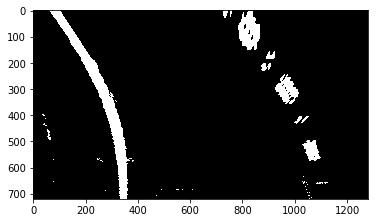

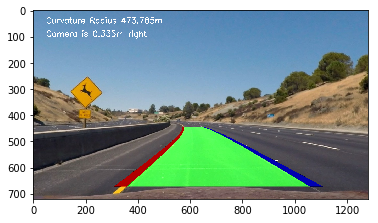

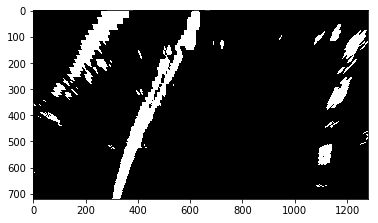

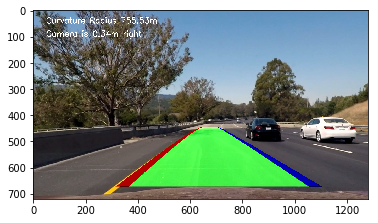

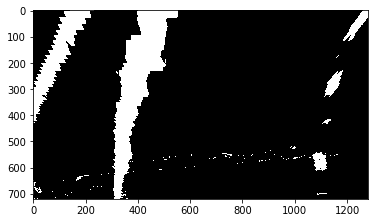

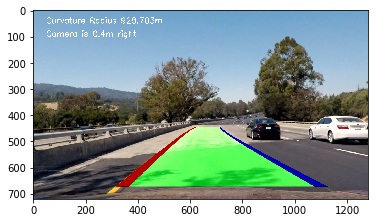

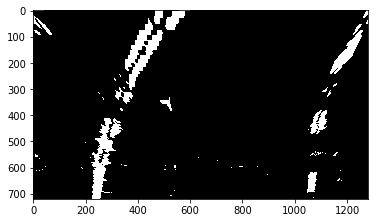

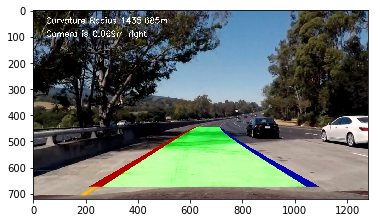

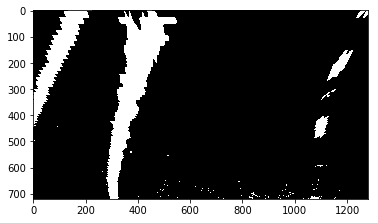

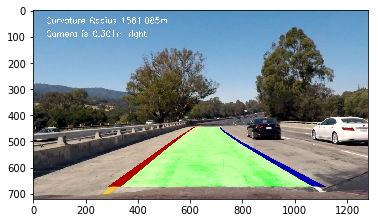

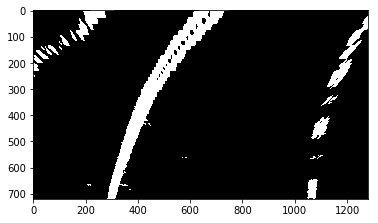

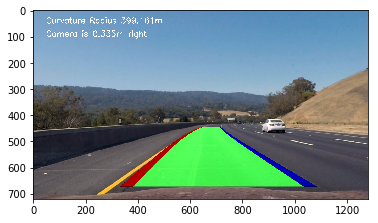

In [13]:
dist_pickle = pickle.load(open("found_corners/calibration_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

images = glob.glob('undistorted_images/undist_image*.jpg')

# For line tracker params to find centres
window_width = 50
window_height = 80
margin = 80


for index, filename in enumerate(images):
    image = mpimg.imread(filename)

    processed_image = np.zeros_like(image[:,:,0])
    gradx = abs_sobel_thresh(image, 'x', 12, 255)
    grady = abs_sobel_thresh(image, 'y', 25, 255)
    color_bin = color_thresholding(image, (100, 255), (50, 255))
    processed_image[(gradx == 1) & (grady == 1) | (color_bin == 1)] = 1
    
    M_values = lane_transform(processed_image)
    
    warped = cv2.warpPerspective(processed_image, M_values[0], (processed_image.shape[1], processed_image.shape[0]), flags = cv2.INTER_LINEAR)
    
    plt.figure()
    plt.imshow(warped, cmap='gray')
    
    curve_centres = line_tracker(Window_width = window_width, Window_height = window_height, Margin = margin, Ym_per_px = 40.0/720, Xm_per_px = 3.7/750, Smooth_factor = 30)

    window_centroids = curve_centres.find_window_centroids(warped)

    left_x_values  = []
    right_x_values = []
    
    if len(window_centroids) > 0:
        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows
        for level in range(0,len(window_centroids)):
            left_x_values.append(window_centroids[level][0])
            right_x_values.append(window_centroids[level][1])
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1)) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1)) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

#         # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
    
    y_values_total     = np.arange(0, warped.shape[0])
    y_values_centroids = np.arange(warped.shape[0] - (window_height/2), 0, -window_height)
    
    # Finding a, b, and c values for the polynomial (2nd degree) for the left lane
    left_poly  = np.polyfit(y_values_centroids, left_x_values, 2)
    left_fit_x = left_poly[0]*y_values_total*y_values_total + left_poly[1]*y_values_total + left_poly[2]
    left_fit_x = np.array(left_fit_x, np.int32)
    
    # Finding properties for the right lane
    right_poly  = np.polyfit(y_values_centroids, right_x_values, 2)
    right_fit_x = right_poly[0]*y_values_total*y_values_total + right_poly[1]*y_values_total + right_poly[2]
    right_fit_x = np.array(right_fit_x, np.int32)
    
    # Making the lanes thicker
    left_lane  = np.array(list(zip(np.concatenate((left_fit_x - (window_width/2), left_fit_x[::-1] + (window_width/2)), axis=0), np.concatenate((y_values_total, y_values_total[::-1]), axis=0))), np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fit_x - (window_width/2), right_fit_x[::-1] + (window_width/2)), axis=0), np.concatenate((y_values_total, y_values_total[::-1]), axis=0))), np.int32)
    middle_fill = np.array(list(zip(np.concatenate((left_fit_x + (window_width/2), right_fit_x[::-1] - (window_width/2)), axis=0), np.concatenate((y_values_total, y_values_total[::-1]), axis=0))), np.int32)

    # Drawing the lanes onto the image
    road = np.zeros_like(image)
    cv2.fillPoly(road, [left_lane], color=[255, 0, 0])
    cv2.fillPoly(road, [right_lane], color=[0, 0, 255])
    cv2.fillPoly(road, [middle_fill], color=[0, 255, 0])
    
    # To make lanes thicker
    road_base = np.zeros_like(image)
    cv2.fillPoly(road_base, [left_lane], color=[255, 255, 255])
    cv2.fillPoly(road_base, [right_lane], color=[255, 255, 255])
    
    # Shift lines into original perspective
    unwarp = cv2.warpPerspective(road, M_values[1], (road.shape[1], road.shape[0]), flags = cv2.INTER_LINEAR)
    unwarp_base = cv2.warpPerspective(road_base, M_values[1], (road.shape[1], road.shape[0]), flags = cv2.INTER_LINEAR)

    line_base = cv2.addWeighted(image, 1.0, unwarp_base, -1.0, 0.0)
    output_image = cv2.addWeighted(line_base, 1.0, unwarp, 0.7, 0.0)
    
    ym_per_px = curve_centres.ym_per_px
    xm_per_px = curve_centres.xm_per_px
    
    # Finding curvature for the on-screen text
    curve_scaled = np.polyfit(np.array(y_values_centroids, np.float32)*ym_per_px, np.array(left_x_values, np.float32)*xm_per_px, 2)
    curve_radius = ((1 + (2 * curve_scaled[0] * y_values_total[-1] * ym_per_px + curve_scaled[1])**2)**1.5) / np.absolute(2 * curve_scaled[0])

    # Finding offset of centre
    lane_centre_pos = (left_fit_x[-1] + right_fit_x[-1]) / 2
    image_offset = (image.shape[1]/2 - lane_centre_pos)*xm_per_px
    
    # Text for the image
    side_position = 'left'
    if image_offset <= 0:
        side_position = 'right'
    
    cv2.putText(output_image, 'Curvature Radius ' + str(round(curve_radius, 3)) + 'm', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.putText(output_image, 'Camera is ' + str(round(abs(image_offset), 3)) + 'm ' + side_position, (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    plt.figure()
    plt.imshow(output_image)
    output_image = cv2.cvtColor(output_image, cv2.COLOR_RGBA2BGRA)
    
    road_lane_filename = 'output_images/road_lanes_with_txt' + str(index) + '.jpg'
    cv2.imwrite(road_lane_filename, output_image)

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [14]:
def lane_finding_pipeline(image):
    
    # Extracting lines using sobel derivatives, saturation and value
    processed_image = np.zeros_like(image[:,:,0])
    gradx = abs_sobel_thresh(image, 'x', 12, 255)
    grady = abs_sobel_thresh(image, 'y', 25, 255)
    color_bin = color_thresholding(image, (100, 255), (50, 255))
    processed_image[(gradx == 1) & (grady == 1) | (color_bin == 1)] = 1
    
    # Transform to top down view
    M_values = lane_transform(processed_image)
    warped = cv2.warpPerspective(processed_image, M_values[0], (processed_image.shape[1], processed_image.shape[0]), flags = cv2.INTER_LINEAR)
    
    # Finding lane centres using convolution
    curve_centres = line_tracker(Window_width = window_width, Window_height = window_height, Margin = margin, Ym_per_px = 40.0/720, Xm_per_px = 4.0/750, Smooth_factor = 30)
    window_centroids = curve_centres.find_window_centroids(warped)

    # Need x-values to determine the polynomial
    left_x_values  = []
    right_x_values = []
    
    for level in range(0,len(window_centroids)):
        left_x_values.append(window_centroids[level][0])
        right_x_values.append(window_centroids[level][1])    

    y_values_total     = np.arange(0, warped.shape[0])
    y_values_centroids = np.arange(warped.shape[0] - (window_height/2), 0, -window_height)
    
    # Finding a, b, and c values for the polynomial (2nd degree) for the left lane
    left_poly  = np.polyfit(y_values_centroids, left_x_values, 2)
    left_fit_x = left_poly[0]*y_values_total*y_values_total + left_poly[1]*y_values_total + left_poly[2]
    left_fit_x = np.array(left_fit_x, np.int32)
    
    # Finding properties for the right lane
    right_poly  = np.polyfit(y_values_centroids, right_x_values, 2)
    right_fit_x = right_poly[0]*y_values_total*y_values_total + right_poly[1]*y_values_total + right_poly[2]
    right_fit_x = np.array(right_fit_x, np.int32)
    
    # Making the lanes thicker
    left_lane  = np.array(list(zip(np.concatenate((left_fit_x - (window_width/2), left_fit_x[::-1] + (window_width/2)), axis=0), np.concatenate((y_values_total, y_values_total[::-1]), axis=0))), np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fit_x - (window_width/2), right_fit_x[::-1] + (window_width/2)), axis=0), np.concatenate((y_values_total, y_values_total[::-1]), axis=0))), np.int32)
    middle_fill = np.array(list(zip(np.concatenate((left_fit_x + (window_width/2), right_fit_x[::-1] - (window_width/2)), axis=0), np.concatenate((y_values_total, y_values_total[::-1]), axis=0))), np.int32)
    
    # Drawing the lanes onto the image
    road = np.zeros_like(image)
    cv2.fillPoly(road, [left_lane], color=[255, 0, 0])
    cv2.fillPoly(road, [right_lane], color=[0, 0, 255])
    cv2.fillPoly(road, [middle_fill], color=[0, 255, 0])
    
    # To make lanes thicker
    road_base = np.zeros_like(image)
    cv2.fillPoly(road_base, [left_lane], color=[255, 255, 255])
    cv2.fillPoly(road_base, [right_lane], color=[255, 255, 255])
    
    # Shift lines into original perspective
    unwarp = cv2.warpPerspective(road, M_values[1], (road.shape[1], road.shape[0]), flags = cv2.INTER_LINEAR)
    unwarp_base = cv2.warpPerspective(road_base, M_values[1], (road.shape[1], road.shape[0]), flags = cv2.INTER_LINEAR)

    line_base = cv2.addWeighted(image, 1.0, unwarp_base, -1.0, 0.0)
    output_image = cv2.addWeighted(line_base, 1.0, unwarp, 0.7, 0.0)
    
    ym_per_px = curve_centres.ym_per_px
    xm_per_px = curve_centres.xm_per_px
    
    # Finding curvature for the on-screen text
    curve_scaled = np.polyfit(np.array(y_values_centroids, np.float32)*ym_per_px, np.array(left_x_values, np.float32)*xm_per_px, 2)
    curve_radius = ((1 + (2 * curve_scaled[0] * y_values_total[-1] * ym_per_px + curve_scaled[1])**2)**1.5) / np.absolute(2 * curve_scaled[0])

    # Finding offset of centre
    lane_centre_pos = (left_fit_x[-1] + right_fit_x[-1]) / 2
    image_offset = (image.shape[1]/2 - lane_centre_pos)*xm_per_px
    
    # Text for the image
    side_position = 'left'
    if image_offset <= 0:
        side_position = 'right'
    
    cv2.putText(output_image, 'Curvature Radius ' + str(round(curve_radius, 3)) + 'm', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.putText(output_image, 'Camera is ' + str(round(abs(image_offset), 3)) + 'm ' + side_position, (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    return output_image

In [15]:
dist_pickle = pickle.load(open("found_corners/calibration_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

images = glob.glob('undistorted_images/undist_image*.jpg')

# For line tracker params to find centres
window_width = 50
window_height = 80
margin = 80

Input_video = 'project_video.mp4'
Output_video = 'lane_finding_output.mp4'

clip1 = VideoFileClip(Input_video)
video_clip = clip1.fl_image(lane_finding_pipeline)
video_clip.write_videofile(Output_video, audio=False)

[MoviePy] >>>> Building video lane_finding_output.mp4
[MoviePy] Writing video lane_finding_output.mp4


100%|█████████▉| 1260/1261 [05:00<00:00,  4.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: lane_finding_output.mp4 



In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(Output_video))